<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writing algorithms which can discover pattersn in visual data, e.g. the camera of a self-driving car.

## Dataset - Food 101 Kaggle
https://www.kaggle.com/datasets/dansbecker/food-101

This data-set was modified to only use 2 classes - pizza 🍕 and steak 🥩. 

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

### Importing the Data

In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2023-02-18 13:38:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  23.2MB/s    in 5.5s    

2023-02-18 13:38:28 (18.9 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



### Inspecting the Data

I need to become one with the data. I need to build my own neural network in my brain (visualizing) before I start writing code.

In [2]:
!ls pizza_steak # list and run from command line

test  train


In [3]:
!ls pizza_steak/train/

pizza  steak


In [4]:
import os
# Walk through the pizza_steak directory and list number of files

for dirpath, dirnames, filenames in os.walk('pizza_steak'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.


In [5]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [6]:
# get teh classnames programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train") # turning the folder into a path object
# Create a list of class-names from the sub-directories
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))

In [7]:
print(class_names)

['pizza' 'steak']


In [8]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random


In [9]:
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # randomly sample 1 of the items in here
  print(random_image)

  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print (f"Image shape: {img.shape}") # show the shape of the image

  return img
  

['242976.jpg']
Image shape: (512, 382, 3)


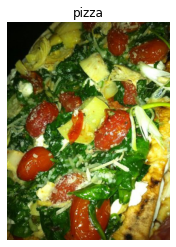

In [10]:
# View a random image from the training dataset
img = view_random_image(target_dir="pizza_steak/test/",
                        target_class="pizza")
 


In [11]:
img.shape

(512, 382, 3)

In [22]:
import tensorflow as tf

In [13]:
tf.constant(img)

<tf.Tensor: shape=(512, 382, 3), dtype=uint8, numpy=
array([[[ 0,  2,  0],
        [ 0,  2,  0],
        [ 0,  2,  0],
        ...,
        [32, 40, 16],
        [38, 46, 22],
        [33, 38, 15]],

       [[ 0,  2,  0],
        [ 0,  2,  0],
        [ 0,  2,  0],
        ...,
        [27, 37, 12],
        [25, 33,  9],
        [16, 21,  0]],

       [[ 0,  2,  0],
        [ 1,  3,  0],
        [ 1,  3,  0],
        ...,
        [24, 34, 10],
        [23, 31,  8],
        [21, 26,  4]],

       ...,

       [[70, 53,  9],
        [55, 38,  0],
        [53, 35,  0],
        ...,
        [87, 46, 28],
        [87, 46, 26],
        [87, 46, 26]],

       [[62, 47,  4],
        [59, 41,  1],
        [64, 46,  6],
        ...,
        [85, 44, 26],
        [84, 43, 25],
        [83, 42, 22]],

       [[56, 41,  0],
        [61, 46,  5],
        [73, 55, 17],
        ...,
        [82, 41, 23],
        [80, 39, 21],
        [78, 37, 17]]], dtype=uint8)>

### Getting the data ready:
* Changing it to numerical format
* Scaling the data - get all the pixel values between 0 and 1

* 🔑 As we discussed before, many machine learning models prefer the values they work with to be between 0 and 1.

In [14]:
(img/255.).dtype

dtype('float64')

# An end-to-end example

Let's build a convolutional neural network to find patterns in our images. More specifically we need a way to:

* Load our images
* Preprocess our iamges
* Build a CNN to find patterns in our images
* Compile the CNN
* Fit the CNN to our training data

In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

`ImageDataGenerator`: Generates batches of tensor image data with real-time data augmentation.

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory

In [16]:
tf.random.set_seed(42)
# preprocess data (get all the pixel values between 0 & 1 i.e. scaling + normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up paths to our data directories
train_dir="/content/pizza_steak/train/"
test_dir="/content/pizza_steak/test/"






# import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               seed=42)


# build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.Conv2D(10,3,
                           activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")                       
])



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [17]:
len(train_data), len(valid_data)

(47, 16)

This is 1500/32 = 46.875

* Notes on the code: 
* `flow_from_directory` takes a path to a directory and generates batches of augmented data. It creates data and labels automatically into a list.
* `class_mode` - states that it's a binary classification

In [18]:
# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        verbose=2,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 - 24s - loss: 0.5461 - accuracy: 0.7167 - val_loss: 0.3794 - val_accuracy: 0.8320 - 24s/epoch - 511ms/step
Epoch 2/5
47/47 - 9s - loss: 0.4241 - accuracy: 0.8260 - val_loss: 0.3328 - val_accuracy: 0.8600 - 9s/epoch - 200ms/step
Epoch 3/5
47/47 - 10s - loss: 0.3961 - accuracy: 0.8220 - val_loss: 0.3839 - val_accuracy: 0.8340 - 10s/epoch - 215ms/step
Epoch 4/5
47/47 - 11s - loss: 0.3616 - accuracy: 0.8500 - val_loss: 0.3472 - val_accuracy: 0.8580 - 11s/epoch - 228ms/step
Epoch 5/5
47/47 - 12s - loss: 0.3148 - accuracy: 0.8693 - val_loss: 0.3256 - val_accuracy: 0.8900 - 12s/epoch - 252ms/step


In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [20]:
53*53*10


28090

## Using the same model was before 
Let's replicate to see if the model we built in a previous section to see if it works with our image data.

In [24]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])


history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 12s 226ms/step - loss: 0.6964 - accuracy: 0.5000 - val_loss: 0.7002 - val_accuracy: 0.4980
Epoch 2/5
47/47 [==============================] - 10s 222ms/step - loss: 0.6927 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 9s 188ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 224ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 11s 235ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [25]:


history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 12s 258ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 224ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 11s 225ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 12s 261ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


In [26]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 150528)            0         
                                                                 
 dense_7 (Dense)             (None, 4)                 602116    
                                                                 
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


* Observation: The results are poor. The accuracy is **0.5** meaning that the model is basically guessing...

Despite having 20x more parameters than our CNN (`model_1`, `model_2` performs terribly.

In [27]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model_3.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics="accuracy")


In [28]:
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 12s 209ms/step - loss: 2.0368 - accuracy: 0.6407 - val_loss: 1.2969 - val_accuracy: 0.5940
Epoch 2/5
47/47 [==============================] - 11s 227ms/step - loss: 0.9074 - accuracy: 0.6853 - val_loss: 1.1519 - val_accuracy: 0.5800
Epoch 3/5
47/47 [==============================] - 11s 226ms/step - loss: 0.6273 - accuracy: 0.7413 - val_loss: 0.4421 - val_accuracy: 0.7880
Epoch 4/5
47/47 [==============================] - 9s 199ms/step - loss: 0.7191 - accuracy: 0.7287 - val_loss: 1.4588 - val_accuracy: 0.6040
Epoch 5/5
47/47 [==============================] - 13s 277ms/step - loss: 0.7082 - accuracy: 0.7460 - val_loss: 0.5158 - val_accuracy: 0.7360


In [29]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_10 (Dense)            (None, 100)               15052900  
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

* Observation: `model_3` has almost 500 times the number of params as `model_1` but without achieving its performance.

* The difference between the 2 is that the CNN seeks to sort out and learn **the most important learning patterns** while the dense layers seeks to learn **all the possible** patterns. 


# Binary Classification (let's break it down)

1. Become one with the data (*visualize visualize visualize*)
2. Preprocess the data (prepared it for our model, by scaling and normalizing, and batchifying)
3. Created the model (started with a baseline
4. Fit the model
5. Evaluate the model
6. Adjust diferent parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied

## 1__Become one with the data



['2146963.jpg']
Image shape: (512, 384, 3)
['221048.jpg']
Image shape: (342, 512, 3)


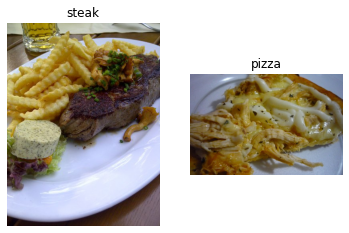

In [31]:
# Visualize data
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("/content/pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("/content/pizza_steak/train/", "pizza")

## 2__Preprocess the data

In [32]:
# Define our directory dataset paths
train_dir = "/content/pizza_steak/train/"
test_dir = "/content/pizza_steak/test/"

Our next step is to turn our data into **batches**. 
A batch is a small subset of the dataset that our model looks at during trainng. This is done for a couple of reasons:
1. 10,000 images or more might not fit into memory.
2. Trying to learn patterns from 10K images in one hit could result in the model not being able to learn very well.

In [33]:
! nvidia-smi #gpu test

Sat Feb 18 13:44:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |   2412MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# this will normalize the data by dividing by the largest possible value.
train_datagen = ImageDataGenerator(rescale = 1./255.)
test_datagen = ImageDataGenerator(rescale = 1./255.)



In [35]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # target directory
                                               target_size=(224,224), # target size of images
                                               class_mode="binary", #type of data you're working with
                                               batch_size=32) # size of subclasses

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [36]:
# Let's see how the data looks like now
# Get a sample of a train data batch

images,labels = train_data.next() # get the "next" batch of images/labels in train data
len(images), len(labels)

(32, 32)

In [44]:
# How many batches are there ( in case we've forgotten)
len(train_data), 1500/32
# 32 images in a batch, therefore a batch of 47

(47, 46.875)

In [39]:



# How does an image tensor look like?
images[:2], images[0].shape

(array([[[[0.69411767, 0.5686275 , 0.50980395],
          [0.69411767, 0.57254905, 0.5019608 ],
          [0.69411767, 0.58431375, 0.5019608 ],
          ...,
          [0.5294118 , 0.427451  , 0.29803923],
          [0.5294118 , 0.427451  , 0.28235295],
          [0.5294118 , 0.43137258, 0.27058825]],
 
         [[0.7058824 , 0.58431375, 0.5137255 ],
          [0.69803923, 0.5882353 , 0.5058824 ],
          [0.6862745 , 0.5764706 , 0.49411768],
          ...,
          [0.54509807, 0.4431373 , 0.3137255 ],
          [0.5294118 , 0.427451  , 0.2901961 ],
          [0.5294118 , 0.427451  , 0.28235295]],
 
         [[0.6862745 , 0.5764706 , 0.4901961 ],
          [0.68235296, 0.57254905, 0.48627454],
          [0.69411767, 0.58431375, 0.5019608 ],
          ...,
          [0.5568628 , 0.45098042, 0.33333334],
          [0.5411765 , 0.43529415, 0.31764707],
          [0.5411765 , 0.43921572, 0.30980393]],
 
         ...,
 
         [[0.7725491 , 0.56078434, 0.41176474],
          [0.76862

* Observation: the values have already been scaled 0 to 1. It's also been resized to 224,224,3

In [40]:
images[7]

array([[[0.60784316, 0.53333336, 0.47450984],
        [0.60784316, 0.53333336, 0.47450984],
        [0.6156863 , 0.5411765 , 0.48627454],
        ...,
        [0.6431373 , 0.5568628 , 0.5137255 ],
        [0.6431373 , 0.5568628 , 0.5137255 ],
        [0.6392157 , 0.5529412 , 0.50980395]],

       [[0.61960787, 0.53333336, 0.4784314 ],
        [0.6156863 , 0.5294118 , 0.47450984],
        [0.6156863 , 0.5294118 , 0.4784314 ],
        ...,
        [0.6431373 , 0.5568628 , 0.5137255 ],
        [0.6431373 , 0.5568628 , 0.5137255 ],
        [0.6431373 , 0.5568628 , 0.5137255 ]],

       [[0.627451  , 0.5372549 , 0.48235297],
        [0.627451  , 0.5372549 , 0.48235297],
        [0.6313726 , 0.5372549 , 0.4901961 ],
        ...,
        [0.6392157 , 0.5529412 , 0.50980395],
        [0.6392157 , 0.5529412 , 0.50980395],
        [0.6313726 , 0.5529412 , 0.50980395]],

       ...,

       [[0.85098046, 0.77647066, 0.75294125],
        [0.85098046, 0.7843138 , 0.7568628 ],
        [0.854902  , 0

In [41]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.],
      dtype=float32)

## 3__Create a CNN model (start with baseline)

A **baseline** is a relatively simple model or existing result that you setup when beginning a machine learning experiment and as you keep experimenting, you try to beat the baseline.

* 🔑 **Note**: In deep learning there's almost an infinite amount of architecture you can create. So one of the best ways is to start with something simple, see if it works on your data and then introduce complexity as required. 

In [48]:
# Make creating the model a bit easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [49]:
# Create our baseline model
model_4 = Sequential([
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu",
           input_shape=(224,224,3)), # input layer so specify input_shape
    Conv2D(10,3, activation="relu"), #filers=10, kernel_size=3
    Conv2D(10,3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid") #output layer, working with binary classification 
])

### Breakdown of the Conv2D layers

`filters` - how many filters (sliding windows) pass over an input tensor. Typical values - 10, 32, 64, 128... the higher the value, the more complex the model. 

`kernel_size` = size of the filter window. can be a tuple (3,3) or an integer (3). The smaller the size, the more features it learns.

`padding` - padds the target tensor with zeros (if `=same`) or leaves the target tensor as is (if `=valid`). If you want to hold the information, keep it as `same`, then the output is the same size as the image; but if you want to don't mind losing information on the boundaries, keep it as `valid` and the output shape gets compressed (usually by 2, so a (7,7) image becomes (5,5) with a 3-size kernel.

`strides `- the number of pixels a filter takes as it moves across an image. default is 1. increasing the stride, compresses the information and the output shape is smaller than the input shape.

https://poloclub.github.io/cnn-explainer/



In [52]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_5 (Flatten)         (None, 475240)            0         
                                                                 
 dense_14 (Dense)            (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


In [53]:
218*218*10

475240

## 4__Fit the model

In [55]:
# check the length of the training and test data generators

In [56]:
len(train_data), len(test_data)

(47, 16)

In [100]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch = len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        #callbacks=[tensorboard_callback],
                        verbose=2)

Epoch 1/5
47/47 - 10s - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.5031 - val_accuracy: 0.8360 - 10s/epoch - 209ms/step
Epoch 2/5
47/47 - 15s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.4700 - val_accuracy: 0.8540 - 15s/epoch - 322ms/step
Epoch 3/5
47/47 - 14s - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.5614 - val_accuracy: 0.8360 - 14s/epoch - 305ms/step
Epoch 4/5
47/47 - 11s - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.5863 - val_accuracy: 0.8360 - 11s/epoch - 224ms/step
Epoch 5/5
47/47 - 10s - loss: 6.1367e-04 - accuracy: 1.0000 - val_loss: 0.6118 - val_accuracy: 0.8380 - 10s/epoch - 203ms/step


* This doesn't give as good performance as `model_1`.

In [ ]:
model_1.evaluate(test_data)

In [ ]:
model_1.summary()

## 5__Evaluating our model

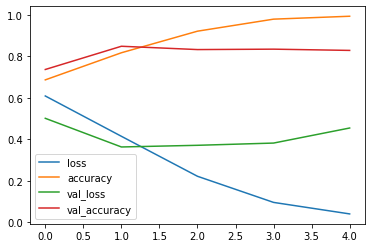

In [58]:
# plot the model's history

import pandas as pd
pd.DataFrame(history_4.history).plot()

In [59]:
# Plot the validation and training curves separately

In [94]:
def plot_loss_curves(history):
  '''
  returns separate loss curves for training and validation metrics
  '''
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # plot loss
  plt.figure()
  plt.plot(epochs, loss, label="training loss")
  plt.plot(epochs, val_loss, label="validation loss")
  plt.title("label")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="validation accuracy")
  plt.title("label")
  plt.xlabel("epochs")
  plt.legend()

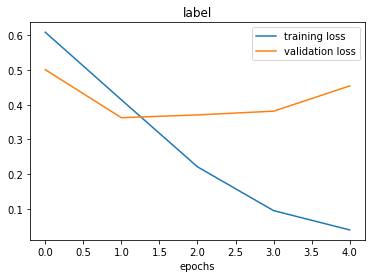

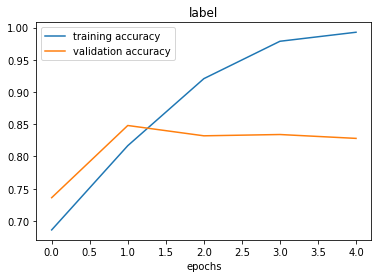

In [95]:
plot_loss_curves(history_4)

* 🔑 **Note**: When the validation loss is increasing, it means the model is overfitting to the training dataset, and the model's ability to generalize to new data is diminished. 

## 6__Adjust the model's parameters

Fitting an ml model comes in 3 steps:
0. Create a baseline
1. beat the baseline by overfitting a larger model
2. reduce overfitting

Ways to induce overfitting:
* increase the number of conv layers,
* increase the number of conv filters,
* add another dense layer to the output of our flattened layer

Reduce overfitting (also known as regularization):
* Add data augmentation
* Add regularization layers *such as MaxPool2D
* Add more data
* Use transfer learning


In [98]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
    Conv2D (10, 3, activation="relu",
            input_shape = (224,224,3)), # first layer should have an input shape
    MaxPool2D (pool_size=2),
    Conv2D (10, 3, activation="relu"),
    MaxPool2D (), # 2 is default pool_size
    Conv2D (10, 3, activation="relu"),
    MaxPool2D (),
    Flatten(),
    Dense (1, activation="sigmoid")
])
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

### Reducing overfitting with `MaxPool2D` - 
downsamples the input by taking the maximum value over the window defined by the pool_size for each dimension along the feature axis.

* In English, it takes the most import features in a "cell", and discards the rest. So a 2,2 pool_size will half the image dimensions. A 3,3 pool_size will 1/3rd the dimensions, etc.

In [102]:
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics="accuracy")
history_5 = model_5.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data = valid_data,
            validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 17s 331ms/step - loss: 0.3392 - accuracy: 0.8567 - val_loss: 0.2966 - val_accuracy: 0.8720
Epoch 2/5
47/47 [==============================] - 10s 223ms/step - loss: 0.3011 - accuracy: 0.8800 - val_loss: 0.2991 - val_accuracy: 0.8720
Epoch 3/5
47/47 [==============================] - 11s 225ms/step - loss: 0.2795 - accuracy: 0.8893 - val_loss: 0.2960 - val_accuracy: 0.8720
Epoch 4/5
47/47 [==============================] - 10s 221ms/step - loss: 0.2663 - accuracy: 0.8980 - val_loss: 0.3158 - val_accuracy: 0.8780
Epoch 5/5
47/47 [==============================] - 14s 290ms/step - loss: 0.2586 - accuracy: 0.8933 - val_loss: 0.2835 - val_accuracy: 0.8960


With fewer parameters, `model_5` outperforms `model_4`

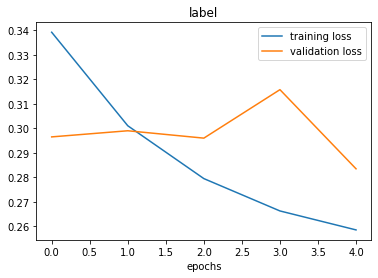

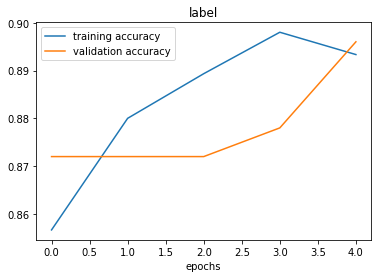

In [103]:
plot_loss_curves(history_5)

### Reducing overfitting with data augmentation

Data augmentation - process of altering training data leading it to have more diversity, and allowing models to learn more generalizable patterns (hopefully!). 

In [108]:
# Create ImageDataGenerator training instance with data augmentation

train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [112]:
# Import data and augment it from training directory
print("Augmented training data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                      target_size=(224,224),
                                                                      batch_size=32,
                                                                      class_mode="binary",
                                                                      shuffle=False) # for demo only
# create non-augmented data batches
print("Non-augmented training data")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               class_mode="binary",
                                               shuffle=False)
print("None-augmented test data")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             class_mode="binary")

Augmented training data
Found 1500 images belonging to 2 classes.
Non-augmented training data
Found 1500 images belonging to 2 classes.
None-augmented test data
Found 500 images belonging to 2 classes.


🔑 **Note**: Data augmentation is usually only performed on the training data (for obvious reasons!). We want to make it 'difficult' for the model to learn from the training data so it can generalize better and not overfit to the training data. Also they don't change in the source directory, only as they're loaded into the model.

* Also the augmentations are applied randomly. They may/may not be applied, and for, example, shear=0.3, this means it can also shear <0.3 etc

In [113]:
# Get sample data - original and augmented

images, labels = train_data.next()
augmented_images, _ = train_data_augmented.next() # labels are not augmented, obviously and we can just use the source label

showing image number: 9


(-0.5, 223.5, 223.5, -0.5)

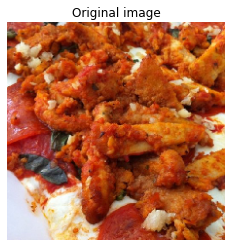

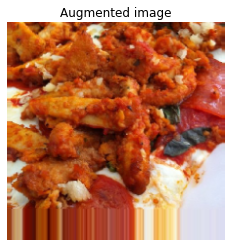

In [145]:
# show original image
import random
random_number = random.randint(0,31)
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title("Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number]);
plt.title("Augmented image")
plt.axis(False)

In [127]:
len(augmented_images)

32

In [154]:
model_6 = Sequential([
    Conv2D(10, 3, activation="relu",
              input_shape=(224,224,3)),
    MaxPool2D(2),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(2),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(1, activation="sigmoid")
])
model_6.compile(loss="binary_crossentropy",
                 optimizer=Adam(),
                metrics="accuracy")
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 10)      

In [155]:
history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 34s 694ms/step - loss: 0.6985 - accuracy: 0.4933 - val_loss: 0.6900 - val_accuracy: 0.5100
Epoch 2/5
47/47 [==============================] - 38s 805ms/step - loss: 0.6939 - accuracy: 0.5073 - val_loss: 0.6913 - val_accuracy: 0.6260
Epoch 3/5
47/47 [==============================] - 34s 712ms/step - loss: 0.6964 - accuracy: 0.5033 - val_loss: 0.6929 - val_accuracy: 0.5940
Epoch 4/5
47/47 [==============================] - 31s 656ms/step - loss: 0.6950 - accuracy: 0.5587 - val_loss: 0.6872 - val_accuracy: 0.5180
Epoch 5/5
47/47 [==============================] - 32s 666ms/step - loss: 0.6940 - accuracy: 0.4713 - val_loss: 0.6929 - val_accuracy: 0.5280


In [ ]:
# Checking our model's training curve...

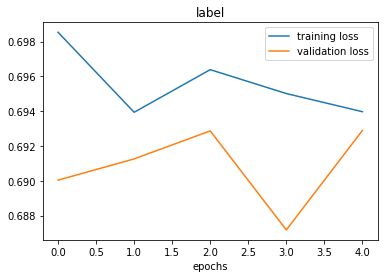

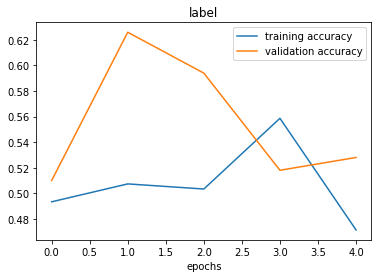

In [156]:
plot_loss_curves(history_6)

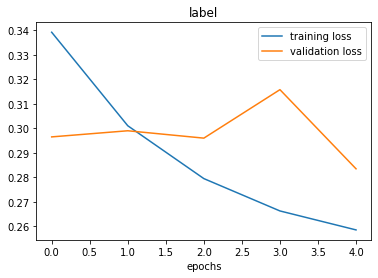

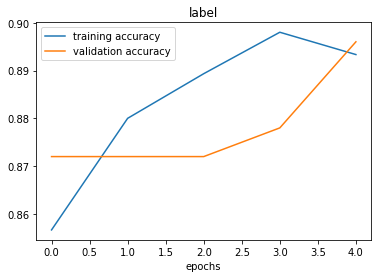

In [151]:
plot_loss_curves(history_5)

* possible that though the results are low in the first 5 epochs compared to the previous model, with longer training, we could get better results. But there's another reason - we didn't shuffle

### Reducing overfitting with data augmentation and shuffling

In [158]:
train_data_augmnented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode="binary",
                                                     shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
model_7 = Sequential([
    Conv2D(10,3,activation="relu",
            input_shape=(224,224,3)),
    MaxPool2D(2),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(2),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])
model_7.compile(loss="binary_crossentropy",
                 optimizer=Adam(),
                metrics=["accuracy"])
# model_7.summary()

In [163]:
history_7 = model_7.fit(train_data_augmnented_shuffled, 
                        epochs=5,
                        steps_per_epoch=len(train_data_augmnented_shuffled),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        verbose=2)

Epoch 1/5
47/47 - 28s - loss: 0.6625 - accuracy: 0.6233 - val_loss: 0.4935 - val_accuracy: 0.8220 - 28s/epoch - 585ms/step
Epoch 2/5
47/47 - 29s - loss: 0.5438 - accuracy: 0.7500 - val_loss: 0.4165 - val_accuracy: 0.8300 - 29s/epoch - 607ms/step
Epoch 3/5
47/47 - 26s - loss: 0.5126 - accuracy: 0.7547 - val_loss: 0.4454 - val_accuracy: 0.7680 - 26s/epoch - 544ms/step
Epoch 4/5
47/47 - 25s - loss: 0.5007 - accuracy: 0.7580 - val_loss: 0.3555 - val_accuracy: 0.8480 - 25s/epoch - 536ms/step
Epoch 5/5
47/47 - 24s - loss: 0.4869 - accuracy: 0.7640 - val_loss: 0.3699 - val_accuracy: 0.8520 - 24s/epoch - 518ms/step


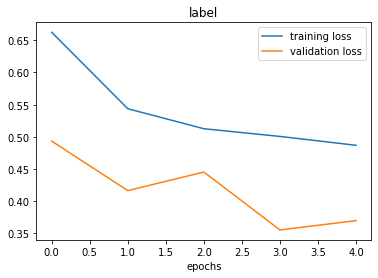

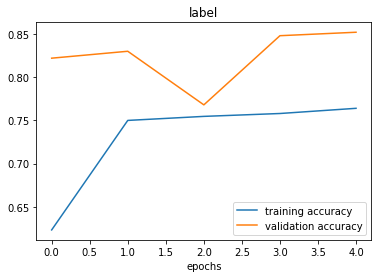

In [164]:
# plot loss curve 
plot_loss_curves(history_7)

* Why does shuffling improve performance?
Because when it's not shuffling, it learns all the patterns in one class (in this case pizza) before it starts learning the patterns in the second class (steak). So the model is biased towards pizza, and doesn't generalize across the classes. By shuffling, it's forced to learn the different patterns almost silmutaenously.

## 7__Repeat until satisfied

As we've beaten our baseline model, here are a few things we can use to improve our model:
1. Increase the number of layers (add more Conv2D/MaxPool2D layers)
2. Increase the number of filters in each convolutional layer (e.g. from 10 to 32, etc)
3. Train for longer (more epochs).
4. Find an ideal learning rate (using the methods we looked at in previous videos)
5. Get more data to give the model more opportunities to learn
6. Use transfer learning to leverage what another image model has learned and adjust it for our own use case.

🛠 **Practice**: recreate the model on the CNN Explainer website and see how it performs for our image classification problem:
https://poloclub.github.io/cnn-explainer/

In [167]:
# Practise:

tf.random.set_seed(42)

model_polo = Sequential([
    Conv2D(10,3,activation="relu", input_shape=(224,224,3)),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Conv2D(10,3,activation="relu"),
    Conv2D(10,3,activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1,activation="sigmoid")
])
model_polo.compile(loss="binary_crossentropy",
                   optimizer=Adam(),
                   metrics=["accuracy"])
model_polo.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_31 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 110, 110, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_33 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 53, 53, 10)       0         
 g2D)                                                

In [ ]:
history_polo = model_polo.fit(train_data_augmnented_shuffled,
               epochs=5,
               steps_per_epoch=len(train_data_augmnented_shuffled),
               validation_data=valid_data,
               validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 26s 545ms/step - loss: 0.6131 - accuracy: 0.6600 - val_loss: 0.4610 - val_accuracy: 0.8260
Epoch 2/5
47/47 [==============================] - 26s 547ms/step - loss: 0.5458 - accuracy: 0.7287 - val_loss: 0.4265 - val_accuracy: 0.8360
Epoch 3/5
47/47 [==============================] - 25s 534ms/step - loss: 0.5008 - accuracy: 0.7560 - val_loss: 0.3641 - val_accuracy: 0.8580
Epoch 4/5
16/47 [=========>....................] - ETA: 13s - loss: 0.4825 - accuracy: 0.7618

In [ ]:
# Making a prediction with our trained model on our own data